## Convolutional Neural Network Model for Audio Classification

<br/>
by Eduardo Garcia Rajo @ 2019<br/>
<br/>
This notebook if part of the project [Urban sounds classification with Covnolutional Neural Networks](https://github.com/GorillaBus/urban-audio-classifier) on my Github.<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

Optimization of the basic CNN model **under construction**

#### Load required libraries

In [92]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime 
import pickle

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GaussianNoise, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint 

from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [93]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
data_path = os.path.abspath('./data')
models_path = os.path.abspath('./models')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

#### Define helper functions

In [94]:
# Helper: Generates MFCC coefficients with Librosa 
def get_mfcc(filename, mfcc_max_padding=0):
    try:
        audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
                
        # Should we require padding?
        pad_width = mfcc_max_padding - mfccs.shape[1]
        if (mfcc_max_padding > 0 & mfccs.shape[1] < mfcc_max_padding):
            pad_width = mfcc_max_padding - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error parsing wavefile: ", filename)
        return None 
    return mfccs

# Given a file returns a list of prediction results
def predict_from_file(file_name, num_rows, num_columns, num_channels):
    # Note we use num_columns as our padding value!
    feature = get_mfcc(file_name, mfcc_max_padding=num_columns) 
    feature = feature.reshape(1, num_rows, num_columns, num_channels)
    predicted_vector = model.predict_classes(feature)
    predicted_class = le.inverse_transform(predicted_vector)
    predicted_proba = model.predict_proba(feature)[0]
    return [
        predicted_class,
        predicted_proba
    ]

def plot_confusion_matrix(y_true, 
                          y_pred, 
                          classes, 
                          normalize=False, 
                          title=None, 
                          cmap=plt.cm.Blues,
                          size=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    return [cm, ax]

# Expects a NumPy array with probabilities, retuns accuracy per class
def acc_per_class(np_probs_array):
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = cm[idx][idx].astype(int)
        total = cm[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

### Load data

In [95]:
# Pre-processed MFCC coefficients and labels & metadata

X = np.load("data/X-v1.npy")
y = np.load("data/y-v1.npy")

In [96]:
# Load the metadata from the generated CSV

metadata = pd.read_csv(metadata_path)

### Data preparation: features + metadata

#### Train / Test split

In [97]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Split the features the with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 174) 	 X train shape: (6986, 40, 174)
y test shape: (1746,) 		 y train shape: (6986,)


#### One hot encode labels

In [98]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))


#### Reshape data

In [99]:
# How data should be organized
num_rows = 40
num_columns = 174 # Remember how we padded the data in the previous notebook?
num_channels = 1

# Reshape to fit the network input (channel last!)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

### A better learning rate
Lets start by finding a better learning rate. I started with **1-e3** -default for the ADAM optimizer-, then raised it to **1.5-e3** and estimated by the training history that this value can be even larger. Let's grid-search between some values of interest:

In [15]:
# Testing learning rates
learning_rates = [2.5e-3]

# Basic model architecture (saved in previous notebook)
model_arch_file = 'basic-model-arch.hdf5'
model_arch_path = os.path.join(models_path, model_arch_file)

# Misc training settings
num_epochs = 60
num_batch_size = 256

# Saved train histories
hists = {}

for lr in learning_rates:
    print("Training with lr: ", lr)
    model = load_model(model_arch_path)
    
    # Compile with current learning rate
    adam = Adam(lr=lr, beta_1=0.99, beta_2=0.999)
    model.compile(
        loss='categorical_crossentropy', 
        metrics=['accuracy'], 
        optimizer=adam)
    
    # Start training
    start = datetime.now()
    history = model.fit(X_train, 
                        y_train_encoded, 
                        batch_size=num_batch_size, 
                        epochs=num_epochs, 
                        validation_data=(X_test, y_test_encoded),
                        verbose=1)

    duration = datetime.now() - start
    print("Training completed in time: ", duration)
    
    
    # Just in case, save also to a file
    print("Saving training history...")
    history_file = "lr_search-" + str(lr) + ".dic"
    history_file_path = os.path.join(data_path, history_file)
    with open(history_file_path, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    

Training with lr:  0.0025


/home/eduugr/miniconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 6986 samples, validate on 1746 samples
Epoch 1/60
6986/6986 [==============================] - 38s 5ms/step - loss: 1.8728 - acc: 0.3289 - val_loss: 1.4973 - val_acc: 0.4931
Epoch 2/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.5378 - acc: 0.4422 - val_loss: 1.2731 - val_acc: 0.5504
Epoch 3/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.4298 - acc: 0.4923 - val_loss: 1.1762 - val_acc: 0.5779
Epoch 4/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.3408 - acc: 0.5195 - val_loss: 1.0938 - val_acc: 0.5802
Epoch 5/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.2607 - acc: 0.5398 - val_loss: 1.0877 - val_acc: 0.6037
Epoch 6/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.2232 - acc: 0.5498 - val_loss: 1.0817 - val_acc: 0.6157
Epoch 7/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.1725 - acc: 0.5750 - val_loss: 1.1102 - val_acc: 0.6002
Epoch 8

Training completed in time:  0:34:53.471532
Saving training history...


In [9]:
# Testing learning rates
learning_rates = [2.5e-3, 5e-3, 7.5e-3, 1e-2, 25e-3]

# Basic model architecture (saved in previous notebook)
model_arch_file = 'basic-model-arch.hdf5'
model_arch_path = os.path.join(models_path, model_arch_file)

# Misc training settings
num_epochs = 60
num_batch_size = 256

# Saved train histories
hists = {}

for lr in learning_rates:
    print("Training with lr: ", lr)
    model = load_model(model_arch_path)
    
    # Compile with current learning rate
    adam = Adam(lr=lr, beta_1=0.99, beta_2=0.999)
    model.compile(
        loss='categorical_crossentropy', 
        metrics=['accuracy'], 
        optimizer=adam)
    
    # Start training
    start = datetime.now()
    history = model.fit(X_train, 
                        y_train_encoded, 
                        batch_size=num_batch_size, 
                        epochs=num_epochs, 
                        validation_data=(X_test, y_test_encoded),
                        verbose=1)

    duration = datetime.now() - start
    print("Training completed in time: ", duration)
    
    # Save current history
    hists[str(lr)] = history
    
    # Just in case, save also to a file
    print("Saving training history...")
    history_file = "lr_search-" + str(lr) + ".dic"
    history_file_path = os.path.join(data_path, history_file)
    with open(history_file_path, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    

W0802 16:24:17.084931 139668583606080 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0802 16:24:17.228776 139668583606080 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Training with lr:  0.025


W0802 16:24:17.302383 139668583606080 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 16:24:17.303966 139668583606080 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0802 16:24:17.304900 139668583606080 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0802 16:24:18.750328 139668583606080 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf

Train on 6986 samples, validate on 1746 samples
Epoch 1/60
6986/6986 [==============================] - 42s 6ms/step - loss: 1.9857 - acc: 0.2949 - val_loss: 4.4958 - val_acc: 0.3184
Epoch 2/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.6984 - acc: 0.3759 - val_loss: 4.6445 - val_acc: 0.2961
Epoch 3/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.6119 - acc: 0.4186 - val_loss: 3.2367 - val_acc: 0.4032
Epoch 4/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.5601 - acc: 0.4256 - val_loss: 2.4479 - val_acc: 0.4192
Epoch 5/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.5093 - acc: 0.4512 - val_loss: 1.8274 - val_acc: 0.5000
Epoch 6/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.4733 - acc: 0.4581 - val_loss: 1.7625 - val_acc: 0.4960
Epoch 7/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.4489 - acc: 0.4734 - val_loss: 1.4974 - val_acc: 0.5515
Epoch 8

Training completed in time:  0:35:02.882280
Saving training history...
Training with lr:  0.005
Train on 6986 samples, validate on 1746 samples
Epoch 1/60
6986/6986 [==============================] - 39s 6ms/step - loss: 1.8351 - acc: 0.3528 - val_loss: 1.5220 - val_acc: 0.4645
Epoch 2/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.4956 - acc: 0.4562 - val_loss: 1.5325 - val_acc: 0.5183
Epoch 3/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.3614 - acc: 0.5096 - val_loss: 1.4601 - val_acc: 0.5372
Epoch 4/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.2895 - acc: 0.5313 - val_loss: 1.1722 - val_acc: 0.5945
Epoch 5/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.2176 - acc: 0.5585 - val_loss: 1.1112 - val_acc: 0.6008
Epoch 6/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.1629 - acc: 0.5839 - val_loss: 1.0064 - val_acc: 0.6449
Epoch 7/60
6986/6986 [========================

6986/6986 [==============================] - 35s 5ms/step - loss: 0.4806 - acc: 0.8348 - val_loss: 0.3373 - val_acc: 0.8860
Epoch 60/60
6986/6986 [==============================] - 35s 5ms/step - loss: 0.4453 - acc: 0.8493 - val_loss: 0.3321 - val_acc: 0.8866
Training completed in time:  0:34:45.303167
Saving training history...
Training with lr:  0.01
Train on 6986 samples, validate on 1746 samples
Epoch 1/60
6986/6986 [==============================] - 38s 5ms/step - loss: 1.8780 - acc: 0.3480 - val_loss: 2.2231 - val_acc: 0.4393
Epoch 2/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.5466 - acc: 0.4393 - val_loss: 2.3411 - val_acc: 0.4404
Epoch 3/60
6986/6986 [==============================] - 34s 5ms/step - loss: 1.4407 - acc: 0.4774 - val_loss: 1.9213 - val_acc: 0.5103
Epoch 4/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.3917 - acc: 0.4953 - val_loss: 1.4730 - val_acc: 0.5504
Epoch 5/60
6986/6986 [==============================] - 3

### Compare validation loss for each learning rate

In [32]:
# Load histories from pickle files
loaded_hists = {}
for lr in learning_rates:
    hist_file = os.path.join(data_path, "lr_search-" + str(lr) + ".dic")
    with open(hist_file, "rb") as file_obj:
        hist = pickle.load(file_obj)
        loaded_hists[str(lr)] = hist

### Train loss comparison

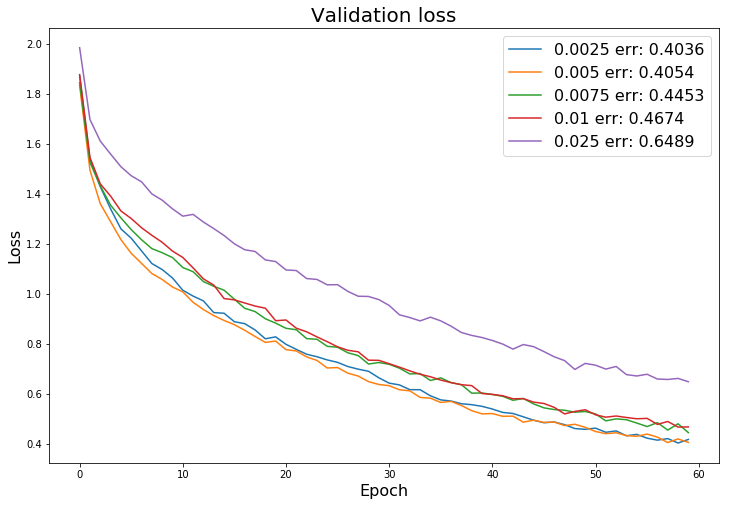

In [67]:
plt.rcParams["figure.figsize"] = [12,8]
minimums = []
for lr in learning_rates:
    plt.plot(loaded_hists[str(lr)]['loss'])
    minimum = min(loaded_hists[str(lr)]['loss'])
    if (minimum < lowest_val):
        lowest_val = minimum
        lowest_lr = str(lr)
    
    minimums.append(minimum)

# Sort learning rates by lowest validation loss and generate legends
sorted_idx = np.argsort(minimums)
legends = []
for i in range(len(minimums)):
    curr_idx = sorted_idx[i]
    legends.append(str(learning_rates[curr_idx]) + " err: %.4f" % minimums[curr_idx])

# Set legends and plot
plt.title('Validation loss', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(legends, loc='upper right', fontsize=16)
plt.show()

### Validation loss comparison

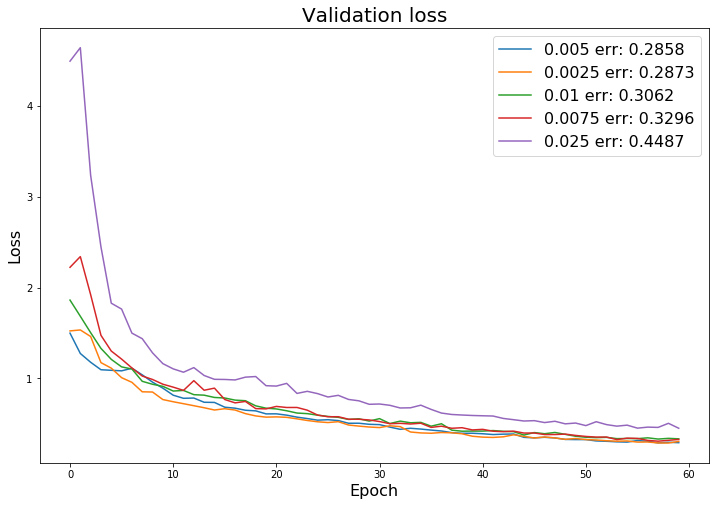

In [68]:
plt.rcParams["figure.figsize"] = [12,8]
minimums = []
for lr in learning_rates:
    plt.plot(loaded_hists[str(lr)]['val_loss'])
    minimum = min(loaded_hists[str(lr)]['val_loss'])
    if (minimum < lowest_val):
        lowest_val = minimum
        lowest_lr = str(lr)
    
    minimums.append(minimum)

# Sort learning rates by lowest validation loss and generate legends
sorted_idx = np.argsort(minimums)
legends = []
for i in range(len(minimums)):
    curr_idx = sorted_idx[i]
    legends.append(str(learning_rates[curr_idx]) + " err: %.4f" % minimums[curr_idx])

# Set legends and plot
plt.title('Validation loss', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(legends, loc='upper right', fontsize=16)
plt.show()

In both cases the best learning rate seems to be between 0.005 and 0.0025. The training curves show that 0.005 performs better during the first 44 epochs, but then it seems that it is outperformed by the lower learning rate. We can keep searching between this two values, we can also add more epochs to the search to see how they perform at the different possible points while we move along the complex dimensional space, but this may end up in a very complex parameter tunning that may require multiple iterations and much time consumption to find a better possible value.<br/>
<br/>
Instead we can use a learning rate schedule, like one that would decrease the learning rate from a maximum to a minimum with some good criteria.<br/>
<br/>
But before messing with learning rate schedules lets search for a better Batch Size.<br/>
<br/>

## A better Batch Size
Lets find a better Batch Size value in the same fashion we searched for better learning rates. We already have references of how the training resulted with a batch size of 256 as it is the value we have been using all the way, so lets compare it with other usual values like 32, 64, 128 and 512.<br/>

In [ ]:
# Testing batch sizes
batch_sizes = [32, 64, 128, 512]

lr = 2.5e-3

# Basic model architecture (saved in previous notebook)
model_arch_file = 'basic-model-arch.hdf5'
model_arch_path = os.path.join(models_path, model_arch_file)

# Misc training settings
num_epochs = 60

# Save histories on the fly also
hists = {}

for bz in batch_sizes:
    print("Training with BZ: ", bz)
    model = load_model(model_arch_path)
    
    # Compile with current learning rate
    adam = Adam(lr=lr, beta_1=0.99, beta_2=0.999)
    model.compile(
        loss='categorical_crossentropy', 
        metrics=['accuracy'], 
        optimizer=adam)
    
    # Start training
    start = datetime.now()
    history = model.fit(X_train, 
                        y_train_encoded, 
                        batch_size=bz, 
                        epochs=num_epochs, 
                        validation_data=(X_test, y_test_encoded),
                        verbose=1)

    duration = datetime.now() - start
    print("Training completed in time: ", duration)
    
    # Save current history
    hists[str(bz)] = history
    
    # Just in case, save also to a file
    print("Saving training history...")
    history_file = "bz_search-" + str(bz) + ".dic"
    history_file_path = os.path.join(data_path, history_file)
    with open(history_file_path, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

### Cyclical learning rate schedule
In simple words, when optimizing, we want to descend to the areas of lowest loss as fast as possible. But to achieve this is not easy in a complex multidimensional space where we can always find special regions (like saddle points) where we may get stuck -even with the very efficient optimizers like ADAM- or we may move very slow until we get out of them. Learning rate schedules proved to be very efficient to address this problem.<br/>
<br/>
Cyclical Learning Rate schedules where introduced by *Leslie Smith* in his 2015 paper, [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186).<br/>
<br/>
We are going to use the Keras implementation by *Brad Kenstler*, that you can find and explore in his [Github repository](https://github.com/bckenstler/CLR).<br/>
<br/>
*A cyclical learning rate is a policy of learning rate adjustment that increases the learning rate off a base value in a cyclical nature. Typically the frequency of the cycle is constant, but the amplitude is often scaled dynamically at either each cycle or each mini-batch iteration.*


#### Setting the cyclical learning rate schedule

In [17]:
from classes.clr_callback import CyclicLR

# Initial / Maximum learning rate
MIN_LR = 1.5e-3
MAX_LR = 5e-3

CLR_METHOD = "triangular"
BATCH_SIZE = 256
STEP_SIZE = 8
NUM_EPOCHS = 60

# Triangular policy
clr_triangular = CyclicLR(
                    mode = CLR_METHOD,
                    base_lr = MIN_LR,
                    max_lr = MAX_LR,
                    step_size = STEP_SIZE * (X_train.shape[0] // BATCH_SIZE))


In [18]:
# Basic model architecture (saved in previous notebook)
model_arch_file = 'basic-model-arch.hdf5'
model_arch_path = os.path.join(models_path, model_arch_file)
model = load_model(model_arch_path)

# Compile with current learning rate
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=Adam())

# Start training
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size = BATCH_SIZE, 
                    epochs = NUM_EPOCHS,
                    callbacks = [clr_triangular],
                    validation_data = (X_test, y_test_encoded),
                    verbose = 1)

duration = datetime.now() - start
print("Training completed in time: ", duration)




W0807 02:23:05.417837 140609476872000 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 02:23:05.639392 140609476872000 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 02:23:05.711094 140609476872000 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 02:23:05.712172 140609476872000 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_defau

Train on 6986 samples, validate on 1746 samples
Epoch 1/60
6986/6986 [==============================] - 42s 6ms/step - loss: 1.8685 - acc: 0.3414 - val_loss: 1.4075 - val_acc: 0.5040
Epoch 2/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.4789 - acc: 0.4684 - val_loss: 1.3457 - val_acc: 0.5292
Epoch 3/60
6986/6986 [==============================] - 36s 5ms/step - loss: 1.3088 - acc: 0.5292 - val_loss: 1.2459 - val_acc: 0.5830
Epoch 4/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.2093 - acc: 0.5610 - val_loss: 1.3076 - val_acc: 0.5601
Epoch 5/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.1111 - acc: 0.6046 - val_loss: 1.0265 - val_acc: 0.6569
Epoch 6/60
6986/6986 [==============================] - 35s 5ms/step - loss: 1.0264 - acc: 0.6401 - val_loss: 0.8479 - val_acc: 0.7102
Epoch 7/60
6986/6986 [==============================] - 35s 5ms/step - loss: 0.9863 - acc: 0.6562 - val_loss: 0.8235 - val_acc: 0.7257
Epoch 8

Training completed in time:  0:35:26.143928


In [19]:
# Save also to a file
print("Saving training history...")
history_file = "lr_search-cyclic-" + str(MIN_LR) + "-" + str(MAX_LR) + ".dic"
history_file_path = os.path.join(data_path, history_file)
with open(history_file_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Saving training history...


In [ ]:
plt.rcParams["figure.figsize"] = [12,8]


plt.plot(history['val_loss'])
minimum = min(loaded_hists[str(lr)]['val_loss'])

legends.append(str(learning_rates[curr_idx]) + " err: %.4f" % minimums[curr_idx])

# Set legends and plot
plt.title('Validation loss', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(legends, loc='upper right', fontsize=16)
plt.show()



### Model definition

In [9]:
model = Sequential()

# Input shape
input_shape = (num_rows, num_columns, num_channels)

# Noise level (standard deviation)
noise_level_inputs = 0.25
noise_level_hidden = 0.25

# General Spatial Dropout rate
spatial_dropout_rate = 0.24

# Gaussian Noise to the input (requires input shape)
model.add(GaussianNoise(noise_level_inputs, input_shape=input_shape))

# Conv 1
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(spatial_dropout_rate))

# Conv 2
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(spatial_dropout_rate))
model.add(MaxPooling2D(pool_size=2))
model.add(GaussianNoise(noise_level_hidden))

# Conv 3
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(spatial_dropout_rate))
model.add(MaxPooling2D(pool_size=2))
model.add(GaussianNoise(noise_level_hidden))

# Conv 4
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(spatial_dropout_rate))
model.add(MaxPooling2D(pool_size=2))
model.add(GaussianNoise(noise_level_hidden))
   
# Conv 5
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(spatial_dropout_rate))


# Reduces each h×w feature map to a single number by taking the average of all h,w values.
model.add(GlobalAveragePooling2D())

# Softmax output
model.add(Dense(num_labels, activation='softmax'))

W0729 20:49:18.508794 139938444756800 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 20:49:18.527918 139938444756800 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 20:49:18.531527 139938444756800 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0729 20:49:18.539873 139938444756800 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use

#### Model optimizer and loss 

Using [ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with default parameters for start from somewhere.
Loss function is categorical cross-entropy as we are predicting between 10 classes.


In [10]:
adam = Adam(lr=1.5e-3, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(X_test, y_test_encoded, verbose=1)
accuracy = 100 * score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

W0729 20:49:19.811780 139938444756800 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 40, 174, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 172, 16)       160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 172, 16)       64        
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 38, 172, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 170, 32)       4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 170, 32)       128       
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 36, 170, 32)       0         
__________

#### Training the model

In [ ]:
num_epochs = 80
num_batch_size = 256
model_file = 'optimized-v0.5.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_data=(X_test, y_test_encoded), 
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

W0729 20:49:31.017239 139938444756800 deprecation.py:323] From /home/eduugr/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6986 samples, validate on 1746 samples
Epoch 1/80
6986/6986 [==============================] - 45s 6ms/step - loss: 1.9706 - acc: 0.3620 - val_loss: 1.8976 - val_acc: 0.4931

Epoch 00001: val_loss improved from inf to 1.89764, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/optimized-v0.5.hdf5
Epoch 2/80
6986/6986 [==============================] - 41s 6ms/step - loss: 1.4882 - acc: 0.4900 - val_loss: 1.4045 - val_acc: 0.5911

Epoch 00002: val_loss improved from 1.89764 to 1.40446, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/optimized-v0.5.hdf5
Epoch 3/80
6986/6986 [==============================] - 41s 6ms/step - loss: 1.3012 - acc: 0.5359 - val_loss: 1.3185 - val_acc: 0.5945

Epoch 00003: val_loss improved from 1.40446 to 1.31851, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/optimized-v0.5.hdf5
Epoch 4/80
6986/6986 [==============================] - 40s 6ms/step - loss: 1.1966 - acc: 0.5814 - v

6986/6986 [==============================] - 41s 6ms/step - loss: 0.1608 - acc: 0.9469 - val_loss: 0.1952 - val_acc: 0.9387

Epoch 00067: val_loss improved from 0.19720 to 0.19522, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/optimized-v0.5.hdf5
Epoch 68/80
6986/6986 [==============================] - 41s 6ms/step - loss: 0.1446 - acc: 0.9529 - val_loss: 0.1867 - val_acc: 0.9416

Epoch 00068: val_loss improved from 0.19522 to 0.18670, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/optimized-v0.5.hdf5
Epoch 69/80
6986/6986 [==============================] - 41s 6ms/step - loss: 0.1428 - acc: 0.9546 - val_loss: 0.1797 - val_acc: 0.9456

Epoch 00069: val_loss improved from 0.18670 to 0.17968, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/optimized-v0.5.hdf5
Epoch 70/80
6986/6986 [==============================] - 41s 6ms/step - loss: 0.1475 - acc: 0.9512 - val_loss: 0.1899 - val_acc: 0.9404

Epoch 00070: val_

### Optional: load previously saved model data

In [14]:
# Optionally load a previously saved model
from keras import models

# Load a full model
model = models.load_model(model_path)

#### Model evaluation

In [15]:
# With noise 90 epochs

# Score on training data
score = model.evaluate(X_train, y_train_encoded, verbose=0)
print("Training Accuracy: ", score[1])

# Score on test data
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9944174062410536
Testing Accuracy:  0.9484536079743201


In [12]:
# Score on training data
score = model.evaluate(X_train, y_train_encoded, verbose=0)
print("Training Accuracy: ", score[1])

# Score on test data
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9866876610363584
Testing Accuracy:  0.95475372279496


#### Save the history
We may want to compare the training history of different test cases

In [18]:
history_file = model_file[:-4] + "dic"
history_file_path = os.path.join(data_path, history_file)

print("Saving training history: {}".format(history_file_path))

with open(history_file_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Saving training history: /mnt/disks/disk-1/projects/urban-audio-classifier/data/optimized-v0.2.dic


#### Analyze the training history: Train vs Test (loss and accuracy metrics)

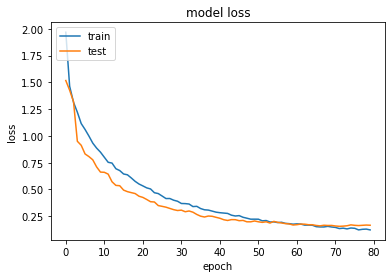

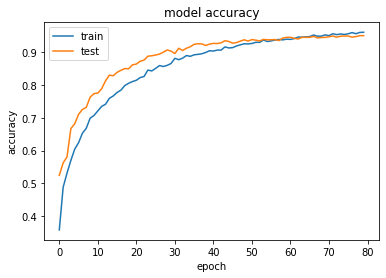

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


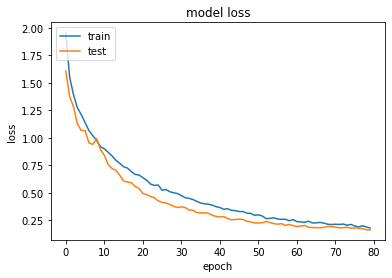

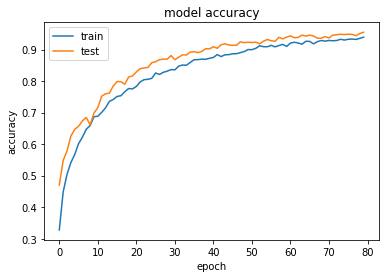

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#### Observations

We have a small and stable gap between train and validation loss, which is usuall sign of a "healthy" training progress with no overfitting. Still, given the slow rate of change of the decreasing loss we may be able to use a higher learning rate to achieve similar results even faster.

At around epoch 70 both loss curves seem to start flatting out, what may be telling that the loss function is getting stuck at a local minima. In that case we may consider trying out different methods to improve the model beyond this point.

Ideas to improve the model performance avoiding overfitting:
* Increasing dropout regularization
* Introducing noise at the input (and also between layers)
* Finding better performing learning rate
* Working a bit more with pre-processed data: amplitude normalization, MFCC data scaling

<br/>
Overall, with this outcome we are in good place to start working on tunning and optimizing the whole process.
<br/>

## Model evaluation
Now let's see how the model performs with data from the test set.

### Random tests on the test set
(Press Ctrl + Enter to re-randomize)<br/>
<br/>

Let's play around a bit by just making predictions on random test data and see how the model performs while also observing probabilies, metrics and listening to the data.


In [19]:
# Get a random file
row = test_meta.sample(1)
idx = row.index.values.astype(int)[0]

fold_num = str(row.iloc[0,5])
file_name = str(row.iloc[0,0])
category = str(row.iloc[0,7])
file_path = audio_path + '/fold'+ fold_num +'/' + file_name
results = predict_from_file(file_path, num_rows, num_columns, num_channels)


# Display results
print("File: {}\n".format(file_path))
print("Result: ", category == results[0][0])
print("True category: {} \t Predicted: {}\n".format(category, results[0][0]))

# Result probabilities
for i in range(len(results[1])): 
    category = le.inverse_transform(np.array([i]))
    print(category[0], ":\t\t{}".format(results[1][i], '.32f'))

IPython.display.Audio(file_path)



File: /mnt/disks/disk-1/projects/urban-audio-classifier/UrbanSound8K/audio/fold2/196384-9-0-2.wav

Result:  True
True category: street_music 	 Predicted: street_music

air_conditioner :		6.559829489560798e-05
car_horn :		0.005177611019462347
children_playing :		9.720007483338122e-07
dog_bark :		6.161081728350837e-06
drilling :		0.00034116339520551264
engine_idling :		2.668466004251968e-05
gun_shot :		1.3948265653596081e-08
jackhammer :		0.11961083859205246
siren :		6.109461310188635e-07
street_music :		0.8747704029083252


## Important to notice:
### You may find very suble results and differences in your local run as the datasets are shuffled each time the notebook is executed.

Keeping that in mind, this is are the observations on my local run results:


### Per class accuracy  
Using the data from the consufion matrix we can elaborate a per-class accuracy table:

In [23]:
# Find per-class accuracy from the confusion matrix data
accuracies = acc_per_class(cm)

pd.DataFrame({
    'CLASS': classes,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

CLASS   ACCURACY
6          Gun Shot  98.648649
8             Siren  98.536585
0   Air Conditioner  98.029557
4          Drilling  97.765363
5     Engine Idling  97.487437
7        Jackhammer  96.969697
1          Car Horn  95.000000
3          Dog bark  93.193717
2  Children Playing  90.640394
9      Street Music  90.206186

As we observe we have good classification results for some classes like Air Conditioning or Siren, but not so good for others like Street Music or Children Playing; I'm expecting to see this cases being misclasified in the confusion matrix, most probably, because the model is not yet being able to distinguish particular patterns for those classes.

#### How classes with less samples did perform

In the first notebook we saw that two particular classes had much less samples than the others (of average 1000 samples each); Car Horn and Gunshot: 

* Both classes have over 95% accuracy
* The rate of other classes being misclassified by any of this two is also very low

<br/>
Most probably, having less samples for this classes is not a problem at all.

### Confusion matrix analisys
Let's see now, with more precision, how well the model predicted the true categories (or how bad!) by preparing and analyzing the confusion matrix.

Confusion matrix, without normalization


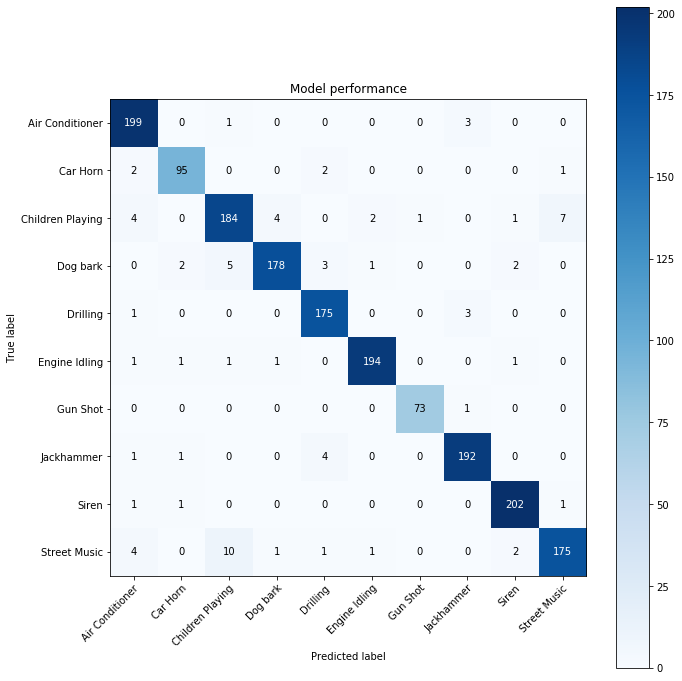

In [21]:
# Ceros after comma (only for printing)
np.set_printoptions(precision=2)

# Class names in the correct order
classes = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

# Ground true classes: index order is preserved!
y_pred = y_test_encoded.argmax(axis=1).tolist()

# Predictions
preds = model.predict(X_test).argmax(axis=1).tolist()

# Prepare the confusion matrix graph
cm, ax = plot_confusion_matrix(y_pred, 
                               preds, 
                               classes,
                               normalize=False,
                               title="Model performance")

# Plot the confusion matrix
plt.show()


#### Observations

We have some classes with very low misclassification rate (good accuracy): 
* Air Conditioner
* Car Horn
* Gun shot

<br/>
There are some interesting cases where the misclassified sample may have very similar patterns to those of the predicted class, for example:<br/>

* Children Playing classified as Street Music, and 3 Street Music as Children Playing
* Dog Barks classified as Car Horn: maybe very short and up-pitched barks?
* Drilling sounds confused with Jack Hammer: actually the difference between this two classes is subtle, a big misclassification rate was expected at this stage.
* Engine Idling samples classified as Jack Hammer: same as above, but still good results.
* Siren sounds classified as Dog Bark: maybe a similar case to the miss classified Dog Barks?

<br/>
<br/>

### Exploring the misclassified

In [ ]:
# Lets first add a predictions column to our test metadata so we can access the sound files
test_meta['pred'] = preds

#### 1. Children playing as Street music

In [383]:
print("Children playing as Street music")

# Children Playing as Street Music
children_as_music = test_meta[(test_meta['classID'] == 2) & (test_meta['pred'] == 9)]

files = []
for idx, row in children_as_music.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 5
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Children playing as Street music

True category: children_playing
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold2/174906-2-0-14.wav


#### Observations

* In most cases you barely listen to any children playing
* In many cases there is significantly loud rhythmic percussive sound, the best example may be: "fold8/72015-2-0-1.wav"
* In several cases you won't hear any children playing instead some adult voices, traffic and loud percussive patterns in the low frequencies

<br/>
<br/>

#### 2. Dog Bark as Car Horn

In [363]:
print("Dog Bark as Car Horn")

# Dog Bark as Car Horn
bark_as_horn = test_meta[(test_meta['classID'] == 3) & (test_meta['pred'] == 1)]

files = []
for idx, row in bark_as_horn.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Set the file index
index = 2
   
# Display results
print("\nTrue category: {}\n".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Dog Bark as Car Horn

True category: dog_bark

File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold1/51022-3-29-0.wav


#### Observations

* All cases are those of short barks, maybe a similar pattern to also short car horn sounds in the dataset
* There's 1 of 4 cases where you can listen to loud traffic at the background mixed with some dog barking; similarly, Car Horn audio in this dataset is generally mixed with loud traffic backgrounds.
* Another 1 of 4 cases in particular has a long and loud high pitched whistle mixed with a very short dog bark.

<br/>
<br/>

#### 3. Siren as Dog Bark

In [368]:
print("Siren as Dog Bark")

# Siren classified as Dog Bark
siren_as_bark = test_meta[(test_meta['classID'] == 8) & (test_meta['pred'] == 3)]

files = []
for idx, row in siren_as_bark.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 0
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Siren as Dog Bark

True category: siren
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold4/156868-8-2-0.wav


#### Observations

* In this two particular cases it seems that the short duration -similar to many examples of dog barks in the dataset- and the very similar pitch confused

<br/>
<br/>

#### 4. Drilling as Jack Hammer

In [382]:
print("Drilling as Jack Hammer")

# Drilling as Jack Hammer
drilling_as_jack = test_meta[(test_meta['classID'] == 4) & (test_meta['pred'] == 7)]

files = []
for idx, row in drilling_as_jack.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 4
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Drilling as Jack Hammer

True category: drilling
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold9/58937-4-2-2.wav


#### Observations

We must first state that this are the most similar classes: a continuous percussive sound with a regular frequency. What makes the difference is that Driller's sound is treble and fast while Jack Hammer's bass and treble, being this stated:

* Most of the misclassified sound are drillers generating percussive bass sounds -many modern drillers will have a switch to function as a percussive hammer!
* Some samples actually sound nothing like a driller and everything like a Jack Hammer. Maybe only the speed is faster than the usual Jack Hammer sound and the model did not catch that pattern?

<br/>
<br/>

#### 5. Drilling as Air Conditioner

In [390]:
print("Drilling as Air Conditioner")

# Drilling as Air Conditioner
drilling_as_aircon = test_meta[(test_meta['classID'] == 4) & (test_meta['pred'] == 0)]

files = []
for idx, row in drilling_as_aircon.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 0
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Drilling as Air Conditioner

True category: drilling
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold1/17913-4-0-2.wav


#### Observations

In every case you can clearly distinguish a driller but perhaps there's a very subtle pattern I think I have recognized in this cases, that could guided to a misclassification: there are many air conditioners that apart from the typical continuous low amplified sound in the low frequencies, there's also some vibrating sound of oscillating amplitude in the mid-low frequencies.

In all of this misclassified samples I observe the same pattern: the drillers are functioning with some oscillating patterns, like those from *some* of the true class.
<br/>
<br/>

#### 6. Jack Hammer as Gunshot

In [394]:
# Jack Hammer as Gunshot

print("Jack Hammer as Gunshot")

jack_as_gunshot = test_meta[(test_meta['classID'] == 7) & (test_meta['pred'] == 6)]

files = []
for idx, row in jack_as_gunshot.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 0
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Jack Hammer as Gunshot

True category: jackhammer
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold2/165775-7-0-0.wav


#### Observations

In this case maybe the very short duration of the audio clip could cause the misclassification. Maybe because all gunshot samples are also very short.
<br/>
<br/>

#### 7. Street Music as Air Conditioner

In [422]:
print("Street Music as Air Conditioner")

# Street Music as Air Conditioner
music_as_aircon = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 0)]

files = []
for idx, row in music_as_aircon.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 3

prediction = predict_from_file(files[index], num_rows, num_columns, num_channels)

print("False positive probability:", prediction[1][0])
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Street Music as Air Conditioner
False positive probability: 0.666828

True category: street_music
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold6/31973-9-0-43.wav


#### Observations

In at least two examples the street music sounds very weak in the background and there is much continuous noise in the mid-to-low frequencies. In the first example, in my opinion, there is nothing like music in the sound, it sounds more like street ambience sound. Still, the model is not being capable of recognizing the real class pattern for this few examples.
<br/>
<br/>

## Conclusion

<br/>
We achieved very acceptable results and a piece of work to start experimenting with tweaking and optimizing once we develop some hypothesis about what the model may be doing wrong and can we solve for it. 

There are clear signs that model is not being able to correctly classify data when the objective sound is not loud enough or it competes strongly with other sound sources observed in the same audio sample.<br/>
<br/>
Some particular cases -like air conditioning- may have patterns -like a constant low frequency- that are likely to appear in other scenarios of outdoors footage.<br/>
<br/>
Drilling and Jack Hammer classes are maybe the most misclassified ones. At the moment, my hypothesis is that both sound types share a very similar pattern (that percussive sound that repeats in a regular frequency), and the key difference between Drilling and Jack Hammer is the speed in which that pattern repeats itself and the pitch: while Jack Hammer sounds bass and slow (percussions over time), drilling is more treble and faster.
<br/>
At first I struggled quite a bit to counter overfitting due to more complex model architectures; It got better once I simplified the model and added Spatial Dropout.<br/>
<br/>
Once I got 90~91% accuracy on the test set, it started to get hard to raise it further while also keeping the loss difference between Train and Test lower than 4%.
After changing the last two Convolutional layer kernels from (2x2) to (3x3) and later  adjusting the Spatial Dropout a bit, I finally got to ~93.5% in the test set.<br/>
<br/>
<br/>
The next step is to try to understand what the model may be doing wrong and see how we can add features to our model for better generalization.

<br/>
<br/>